In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score


# Load futures data
print("--- Loading Correct Feature Datasets ---")
try:
    # Load the SPOT-LED shock data (Spot shocks predicting Futures moves)
    df_spot_led = pd.read_csv("outputs/model1_spot_led_microstructure.csv")

    # Load the FUTURES-LED shock data (Futures shocks predicting Spot moves)
    df_fut_led = pd.read_csv("outputs/model2_fut_led_microstructure.csv")

    # Load the original full spot tick data for momentum analysis
    full_spot_ticks = pd.read_csv("TRB_USDT/Archive/trb_usdt_spot_export.csv")
    full_spot_ticks["time"] = pd.to_datetime(full_spot_ticks["time"])
    full_spot_ticks["mid_price"] = (
        full_spot_ticks["bid_price"] + full_spot_ticks["ask_price"]
    ) / 2
    full_spot_ticks.sort_values("time", inplace=True)

    print("Data loaded successfully.")
    print(f"Spot-Led Events: {len(df_spot_led)}")
    print(f"Futures-Led Events: {len(df_fut_led)}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print(
        "Please ensure the feature CSV files from the first script exist in the 'outputs/' directory."
    )
    exit()

--- Loading Correct Feature Datasets ---
Data loaded successfully.
Spot-Led Events: 15006
Futures-Led Events: 21457



### 2. ANALYSIS FOR SPOT-LED MODEL (Spot -> Futures) ###

--- XGBoost Results for SPOT-LED Model ---
              precision    recall  f1-score   support

           0       0.51      0.38      0.44      1316
           1       0.60      0.72      0.65      1686

    accuracy                           0.57      3002
   macro avg       0.56      0.55      0.55      3002
weighted avg       0.56      0.57      0.56      3002


Feature Importance Scores:
past_trade_vol_10ms      0.260471
time_since_prev_shock    0.249152
spread                   0.247512
abs_shock_size           0.242865
dtype: float32


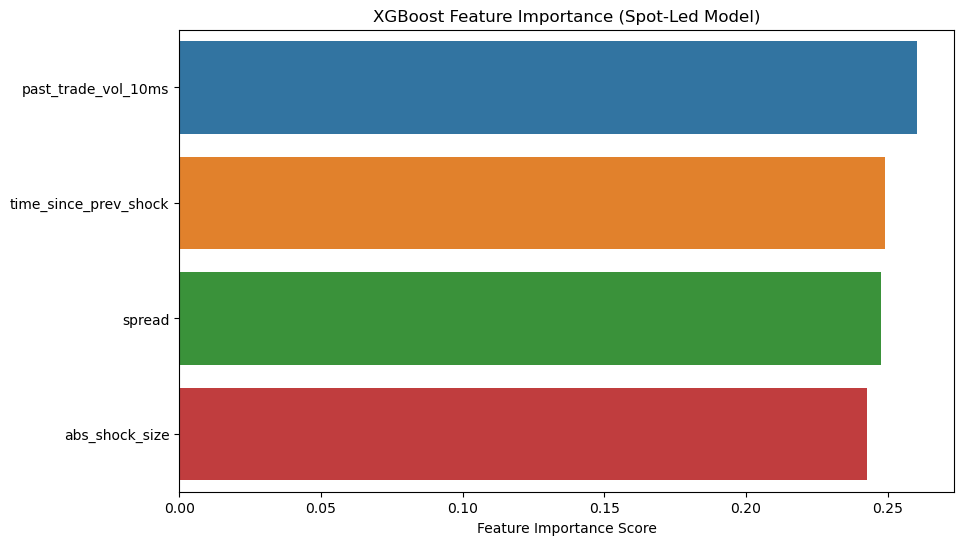


--- Simple HIGH-VOLUME Threshold Model (Spot-Led) ---
Optimal HIGH Volume Threshold found: 102.41
Hit Rate on Best Training Subset: 64.19%

Results on UNSEEN Test Data:
              precision    recall  f1-score   support

           0       0.45      0.89      0.60      1316
           1       0.65      0.16      0.25      1686

    accuracy                           0.48      3002
   macro avg       0.55      0.52      0.43      3002
weighted avg       0.56      0.48      0.40      3002



In [2]:
print("\n" + "=" * 50)
print("### 2. ANALYSIS FOR SPOT-LED MODEL (Spot -> Futures) ###")
print("=" * 50)

# --- Define X and y for the Spot-Led model ---
features = [
    "time_since_prev_shock",
    "abs_shock_size",
    "past_trade_vol_10ms",
    "spread",
]
X_spot = df_spot_led[features]
y_spot = df_spot_led["target_fut_followed"]  # Correct target column

# --- ML Model Training ---
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_spot, y_spot, test_size=0.2, random_state=42, stratify=y_spot
)

xgb_spot = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42
)
xgb_spot.fit(X_train_s, y_train_s)
preds_spot = xgb_spot.predict(X_test_s)

print("\n--- XGBoost Results for SPOT-LED Model ---")
print(classification_report(y_test_s, preds_spot))

# --- Feature Importance for Spot-Led Model ---
feature_importances_spot = pd.Series(
    xgb_spot.feature_importances_, index=X_train_s.columns
).sort_values(ascending=False)
print("\nFeature Importance Scores:")
print(feature_importances_spot)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_spot, y=feature_importances_spot.index)
plt.title("XGBoost Feature Importance (Spot-Led Model)")
plt.xlabel("Feature Importance Score")
plt.show()

# --- Simple Threshold Model for Spot-Led (High Volume should be better) ---
print("\n--- Simple HIGH-VOLUME Threshold Model (Spot-Led) ---")
train_df_s = pd.concat([X_train_s, y_train_s], axis=1)
best_hit_rate_s = 0
best_threshold_s = 0
# For spot-led, we hypothesize HIGH volume is predictive. So we search percentiles from high to low.
for p in np.linspace(0.5, 0.99, 50):
    threshold = train_df_s["past_trade_vol_10ms"].quantile(p)
    high_vol_subset = train_df_s[train_df_s["past_trade_vol_10ms"] >= threshold]
    if len(high_vol_subset) > 0:
        hit_rate = high_vol_subset["target_fut_followed"].mean()
        if hit_rate > best_hit_rate_s:
            best_hit_rate_s = hit_rate
            best_threshold_s = threshold

print(f"Optimal HIGH Volume Threshold found: {best_threshold_s:.2f}")
print(f"Hit Rate on Best Training Subset: {best_hit_rate_s:.2%}")

# Evaluate on test set
threshold_preds_s = (X_test_s["past_trade_vol_10ms"] >= best_threshold_s).astype(int)
print("\nResults on UNSEEN Test Data:")
print(classification_report(y_test_s, threshold_preds_s))


### 3. ANALYSIS FOR FUTURES-LED MODEL (Futures -> Spot) ###

--- XGBoost Results for FUTURES-LED Model ---
              precision    recall  f1-score   support

           0       0.48      0.23      0.31      1494
           1       0.68      0.86      0.76      2798

    accuracy                           0.64      4292
   macro avg       0.58      0.55      0.54      4292
weighted avg       0.61      0.64      0.60      4292

Model Hit Rate (Precision for 'Follow' class): 67.82%
This means when the model generates a signal, it is correct this percentage of the time.

Feature Importance Scores:
time_since_prev_shock    0.300238
spread                   0.245250
past_trade_vol_10ms      0.231718
abs_shock_size           0.222794
dtype: float32


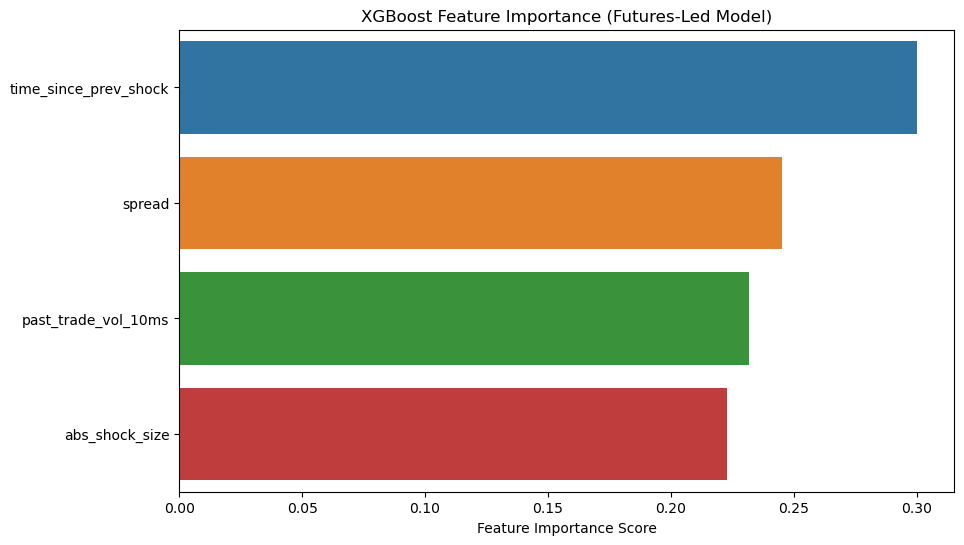

In [3]:
print("\n" + "=" * 50)
print("### 3. ANALYSIS FOR FUTURES-LED MODEL (Futures -> Spot) ###")
print("=" * 50)

# --- Define X and y for the Futures-Led model ---
X_fut = df_fut_led[features]
y_fut = df_fut_led["target_spot_followed"]  # Correct target column

# --- ML Model Training ---
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fut, y_fut, test_size=0.2, random_state=42, stratify=y_fut
)

xgb_fut = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_fut.fit(X_train_f, y_train_f)
preds_fut = xgb_fut.predict(X_test_f)

print("\n--- XGBoost Results for FUTURES-LED Model ---")
print(classification_report(y_test_f, preds_fut))


# Calculate the precision for class 1, which is our "Hit Rate"
# This tells us: "Of all the times the model predicted a 'follow', how often was it right?"
model_hit_rate = precision_score(y_test_f, preds_fut, pos_label=1)

print(f"Model Hit Rate (Precision for 'Follow' class): {model_hit_rate:.2%}")
print(
    "This means when the model generates a signal, it is correct this percentage of the time."
)


# --- Feature Importance for Futures-Led Model ---
feature_importances_fut = pd.Series(
    xgb_fut.feature_importances_, index=X_train_f.columns
).sort_values(ascending=False)
print("\nFeature Importance Scores:")
print(feature_importances_fut)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_fut, y=feature_importances_fut.index)
plt.title("XGBoost Feature Importance (Futures-Led Model)")
plt.xlabel("Feature Importance Score")
plt.show()

In [4]:
print("\n--- Simple LOW-VOLUME Threshold Model (Futures-Led) ---")
train_df_f = pd.concat([X_train_f, y_train_f], axis=1)
best_hit_rate_f = 0
best_threshold_f = 0
# For futures-led, we hypothesize LOW volume is predictive. So we search percentiles from low to high.
for p in np.linspace(0.01, 0.5, 50):
    threshold = train_df_f["past_trade_vol_10ms"].quantile(p)
    low_vol_subset = train_df_f[train_df_f["past_trade_vol_10ms"] <= threshold]
    if len(low_vol_subset) > 0:
        hit_rate = low_vol_subset["target_spot_followed"].mean()
        if hit_rate > best_hit_rate_f:
            best_hit_rate_f = hit_rate
            best_threshold_f = threshold

print(f"Optimal LOW Volume Threshold found: {best_threshold_f:.2f}")
print(f"Hit Rate on Best Training Subset: {best_hit_rate_f:.2%}")

# Evaluate on test set
threshold_preds_f = (X_test_f["past_trade_vol_10ms"] <= best_threshold_f).astype(int)
print("\nResults on UNSEEN Test Data:")
print(classification_report(y_test_f, threshold_preds_f))


--- Simple LOW-VOLUME Threshold Model (Futures-Led) ---
Optimal LOW Volume Threshold found: 0.00
Hit Rate on Best Training Subset: 70.26%

Results on UNSEEN Test Data:
              precision    recall  f1-score   support

           0       0.37      0.82      0.51      1494
           1       0.72      0.24      0.36      2798

    accuracy                           0.44      4292
   macro avg       0.54      0.53      0.44      4292
weighted avg       0.59      0.44      0.41      4292




### 4. MOMENTUM ANALYSIS (For successful Futures -> Spot signals) ###
       momentum_100ms  momentum_500ms   momentum_1s   momentum_5s  \
count    13986.000000    13986.000000  13986.000000  13986.000000   
mean         0.000622        0.000636      0.000602      0.000875   
std          0.002793        0.005307      0.007311      0.014489   
min         -0.020447       -0.030797     -0.033552     -0.082661   
25%         -0.000526       -0.001214     -0.001830     -0.003652   
50%          0.000349        0.000203      0.000139     -0.000010   
75%          0.001521        0.002410      0.002733      0.004304   
max          0.017651        0.031370      0.033918      0.084737   

       momentum_30s  
count  13986.000000  
mean       0.000528  
std        0.014860  
min       -0.058976  
25%       -0.005793  
50%       -0.000249  
75%        0.005815  
max        0.063026  


C:\Users\dogut\AppData\Local\Temp\ipykernel_23576\2960388092.py:8: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_signal_ns = signal_events["time"].astype("datetime64[ns]").values.astype(np.int64)
C:\Users\dogut\AppData\Local\Temp\ipykernel_23576\2960388092.py:9: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  t_spot_ns = full_spot_ticks["time"].astype("datetime64[ns]").values.astype(np.int64)


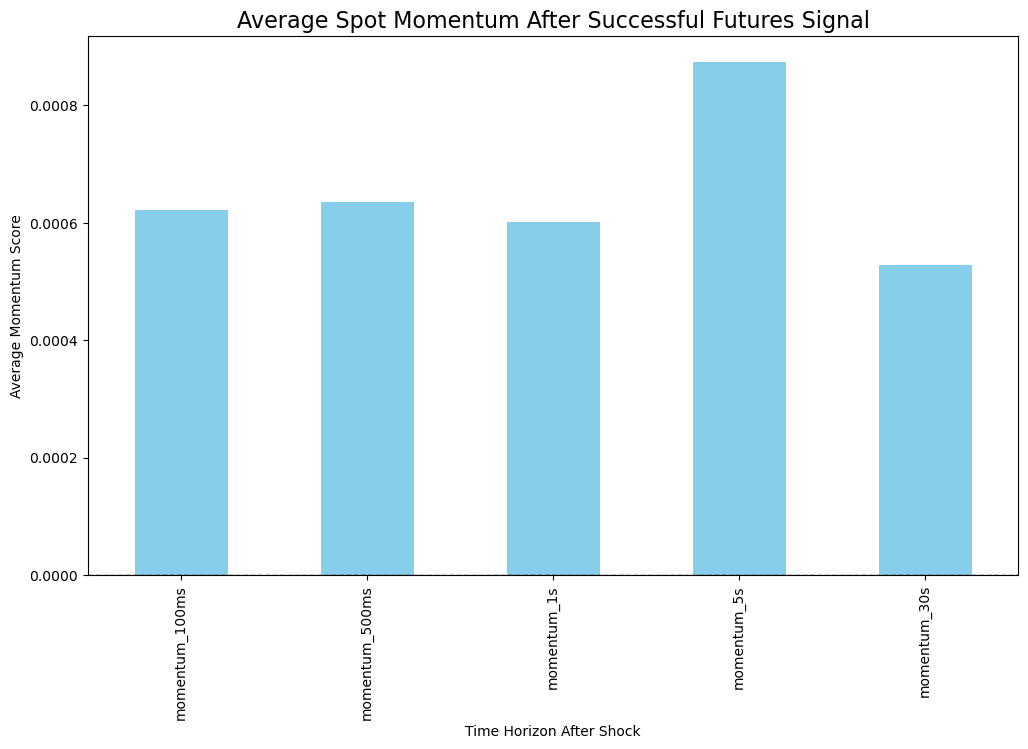

In [5]:
print("\n" + "=" * 50)
print("### 4. MOMENTUM ANALYSIS (For successful Futures -> Spot signals) ###")
print("=" * 50)

signal_events = df_fut_led[df_fut_led["target_spot_followed"] == 1].copy()
signal_events["time"] = pd.to_datetime(signal_events["time"])

t_signal_ns = signal_events["time"].astype("datetime64[ns]").values.astype(np.int64)
t_spot_ns = full_spot_ticks["time"].astype("datetime64[ns]").values.astype(np.int64)
spot_mid_price = full_spot_ticks["mid_price"].to_numpy()

horizons_ns = {
    "100ms": 100 * 1e6,
    "500ms": 500 * 1e6,
    "1s": 1e9,
    "5s": 5e9,
    "30s": 30e9,
}
momentum_results = signal_events.copy()

for name, horizon_ns in horizons_ns.items():
    future_indices = np.searchsorted(t_spot_ns, t_signal_ns + horizon_ns, side="left")
    future_prices = np.full_like(future_indices, np.nan, dtype=float)
    valid_mask = future_indices < len(spot_mid_price)
    future_prices[valid_mask] = spot_mid_price[future_indices[valid_mask]]

    price_at_shock = momentum_results["mid_price"].to_numpy()
    shock_direction = momentum_results["shock_dir"].to_numpy()

    momentum_score = (future_prices - price_at_shock) / price_at_shock * shock_direction
    momentum_results[f"momentum_{name}"] = momentum_score

print(
    momentum_results[
        [c for c in momentum_results.columns if "momentum" in c]
    ].describe()
)
avg_momentum = momentum_results[[f"momentum_{name}" for name in horizons_ns]].mean()

plt.figure(figsize=(12, 7))
avg_momentum.plot(kind="bar", color="skyblue")
plt.title("Average Spot Momentum After Successful Futures Signal", fontsize=16)
plt.ylabel("Average Momentum Score")
plt.xlabel("Time Horizon After Shock")
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.show()